In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
tme_test_stakeoff
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
table_path = "celo-testnet.tme_test_stakeoff.tme_stakeoff_test_20200323"
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_20200323


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.jsonPayload.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks['blocktime'] = df_blocks[::-1].diff(axis=0).timestamp

df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,1.757700e+04,17577.000000,1.757700e+04,17577.0,17577.000000,17576.000000
mean,1.579632e+09,185874.630540,5.406806e+04,20000000.0,1.095352,237.849283
std,1.256356e+06,249556.918505,1.812114e+05,0.0,0.709524,525.825536
min,1.578698e+09,500.000000,0.000000e+00,20000000.0,1.000000,5.000000
25%,1.578768e+09,14347.000000,0.000000e+00,20000000.0,1.000000,5.000000
50%,1.578790e+09,18741.000000,0.000000e+00,20000000.0,1.000000,5.000000
75%,1.580412e+09,340600.000000,0.000000e+00,20000000.0,1.000000,500.000000
max,1.582878e+09,822500.000000,1.095853e+07,20000000.0,14.000000,48283.000000


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.582878e+09,822500.0,375081.0,20000000.0,1,1641.0
1,1.582877e+09,822400.0,208426.0,20000000.0,1,1664.0
2,1.582875e+09,822300.0,108726.0,20000000.0,1,1787.0
3,1.582873e+09,822200.0,177222.0,20000000.0,1,1072.0
4,1.582872e+09,822100.0,91069.0,20000000.0,1,1110.0


last block  : 822500 on 1582878345.0
first block : 500 on 1578697906.0
blocks load : 17577
transactions: 19253
mean gasUsed: 54068 GcWei
mean blocktime: 238 s


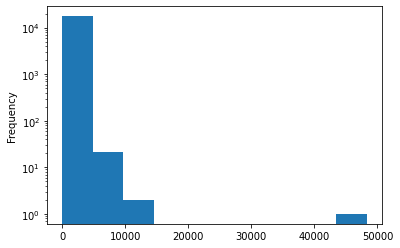

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.0f} s")

In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
count,96316.000000,1.925500e+04,1.926100e+04,19264.000000,1.927100e+04,1.927100e+04,1.926500e+04
mean,173152.476951,6.003676e+26,1.609782e+24,6.261635,6.263274e+24,9.975318e+23,1.129691e+26
std,242087.211679,5.151971e+23,1.224152e+22,4.435080,4.432272e+24,7.018841e+21,1.087346e+25
min,500.000000,6.000000e+26,1.569455e+24,0.995000,9.868052e+23,8.558890e+23,1.069011e+26
25%,14117.000000,6.000292e+26,1.608876e+24,1.000000,1.000659e+24,9.983047e+23,1.069011e+26
50%,18886.000000,6.000393e+26,1.616437e+24,10.000000,9.995200e+24,9.995200e+23,1.069011e+26
75%,295125.000000,6.006270e+26,1.616465e+24,10.000000,9.995200e+24,9.995200e+23,1.142698e+26
max,822500.000000,6.017675e+26,1.616726e+24,10.000000,1.000000e+25,1.002487e+24,1.481719e+26


In [9]:
df = df_state \
    .groupby('blockNumber').max() \
    .merge(df_blocks, left_on='blockNumber', right_on='blockNumber', suffixes=('_tme', '_block'))
df['datetime_block'] = pd.to_datetime(df['timestamp_block'],unit='s')
df.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
17557,822100.0,2020-03-23 16:58:31.006895+00:00,6.017649e+26,1.569503e+24,1.004,9.908442e+23,9.868966e+23,1.481309e+26,1.582872e+09,91069.0,20000000.0,1,1110.0,2020-02-28 06:43:01
17558,822200.0,2020-03-23 16:58:31.447293+00:00,6.017653e+26,1.569504e+24,1.004,9.908442e+23,9.868966e+23,1.481309e+26,1.582873e+09,177222.0,20000000.0,1,1072.0,2020-02-28 07:00:53
17559,822300.0,2020-03-23 16:58:32.036633+00:00,6.017661e+26,1.569455e+24,1.005,9.919736e+23,9.870384e+23,1.481719e+26,1.582875e+09,108726.0,20000000.0,1,1787.0,2020-02-28 07:30:40
17560,822400.0,2020-03-23 16:58:32.626364+00:00,6.017668e+26,1.569456e+24,1.004,9.922852e+23,9.867094e+23,1.481719e+26,1.582877e+09,208426.0,20000000.0,1,1664.0,2020-02-28 07:58:24
17561,822500.0,2020-03-23 16:58:33.364458+00:00,6.017675e+26,1.569458e+24,1.005,9.909564e+23,9.870084e+23,1.481719e+26,1.582878e+09,375081.0,20000000.0,1,1641.0,2020-02-28 08:25:45


Text(0, 0.5, 'SortedOracles.medianRate')

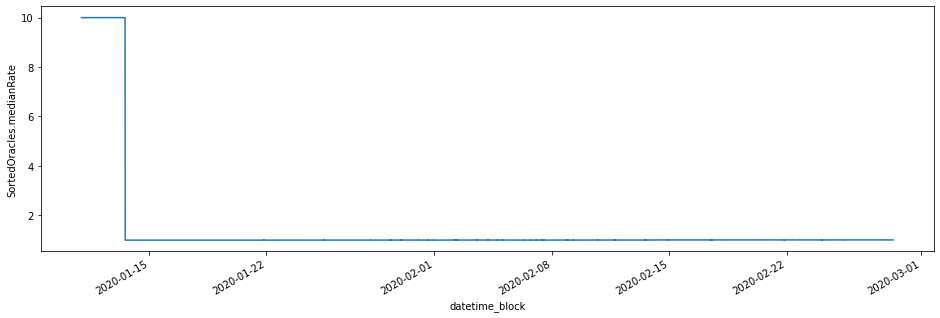

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]
df_sortedOracles = df.set_index('datetime_block')['medianRate']
ax = df_sortedOracles.plot()
ax.set_ylabel("SortedOracles.medianRate")

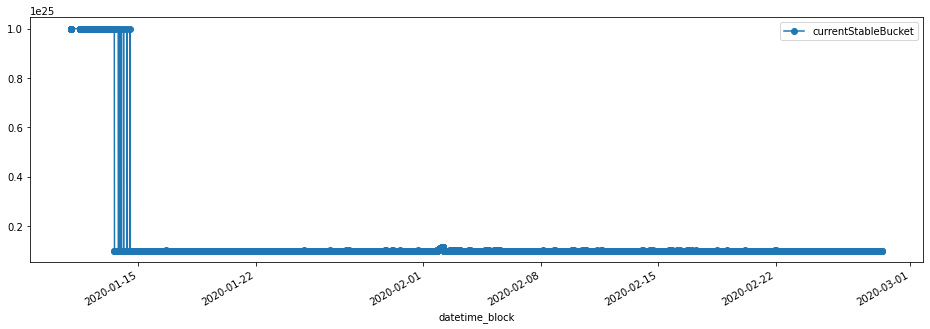

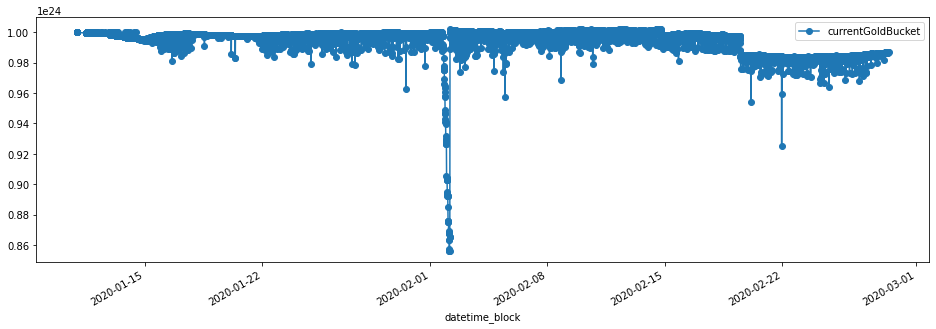

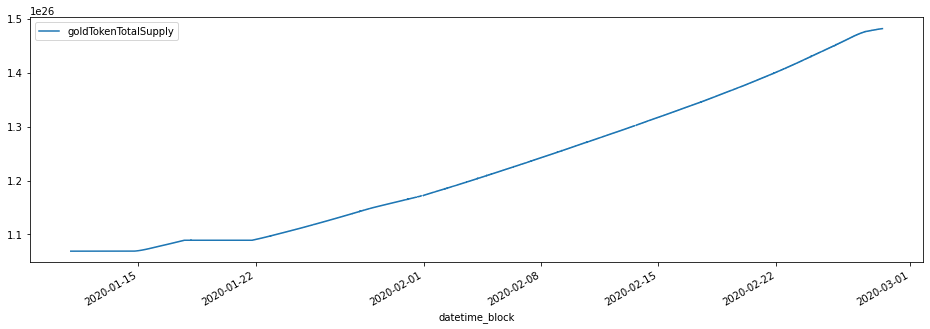

In [11]:
df_stableToken = df.set_index('datetime_block')[['currentStableBucket']].astype('float')
df_stableToken.plot(marker='o')
df_stableToken = df.set_index('datetime_block')[['currentGoldBucket']].astype('float')
df_stableToken.plot(marker='o')
df_goldToken = df.set_index('datetime_block')[['goldTokenTotalSupply']]
ax = df_goldToken.plot()

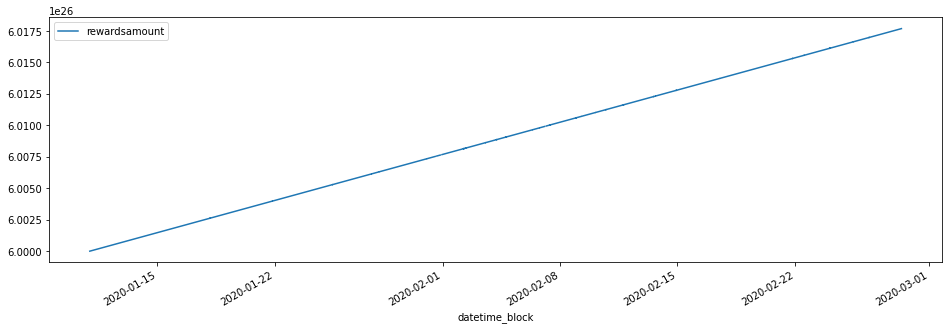

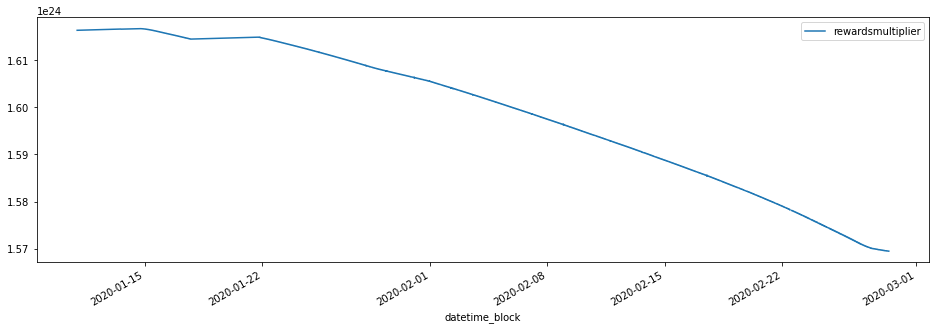

In [12]:
df_rewardsAmount = df.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()